# Predict Similarity in Question Pairs
- The goal of this project is to predict which of the provided pairs of questions contain two questions with the same meaning.
- Our mission is to create a predictive model that discerns semantic similarity between pairs of questions, navigating the challenges posed by subjective human labeling.

## Dataset Overview:
### **Quora Question Pairs**

- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question

- is_duplicate - *the target variable*, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/question-pairs/train.csv


## 1. Import necessary dependencies

In [2]:
import numpy as np               # For numerical analysis
import pandas as pd              # For data manipulation 
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns            # For data visualization

# For text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# For model building
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 2. EDA (Exploratory Data Analysis)
### 2.1 Data Collection

In [3]:
df = pd.read_csv("/kaggle/input/question-pairs/train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape 

(404290, 6)

- The dataset contains 404290 question pairs and each row has 6 columns attached to it.
- `is_duplicate` is the target variable here

In [5]:
df['is_duplicate'].value_counts() # Get unique target labels

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

- The dataset contains `255027` non duplicated question pairs and `149263` duplicated question pairs

#### Dataset Distribution

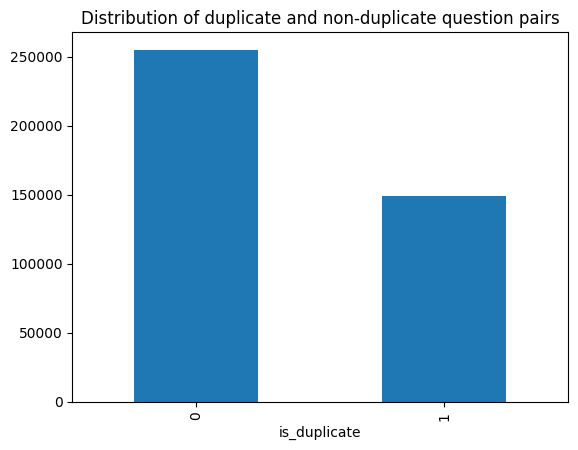

In [6]:
df['is_duplicate'].value_counts().plot(kind='bar',
                                       title="Distribution of duplicate and non-duplicate question pairs")
plt.show()

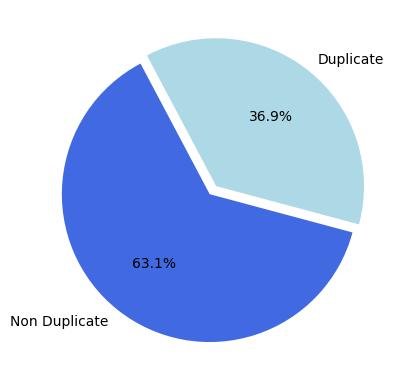

In [7]:
pair = df[df['is_duplicate'] == 1].shape[0]
not_pair = df[df['is_duplicate'] == 0].shape[0]

#Parameters of pie charts
sizes = [pair, not_pair]
explode = [0.07,0]
labels=['Duplicate', "Non Duplicate"]
colors = ['lightblue','royalblue']
autopct = '%1.1f%%'
title="Distribution of duplicate and non-duplicate question pairs"

plt.pie(x=sizes, startangle=345 , explode=explode, labels=labels, 
        colors=colors, autopct=autopct)
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
# Null values
# df.fillna(method='bfill')
df.isnull().sum()


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
# Repeated Questions
qid = pd.concat([df['qid1'],df['qid2']])
print("Number of unique questions", np.unique(qid).shape[0])

x = qid.value_counts()>1 # x is a boolean variable
print("Number of repeated questions", x[x].shape[0]) # x[x], it filters out only the elements in x where the value is True

Number of unique questions 537933
Number of repeated questions 111780


In [11]:
np.unique(qid).shape[0]

537933

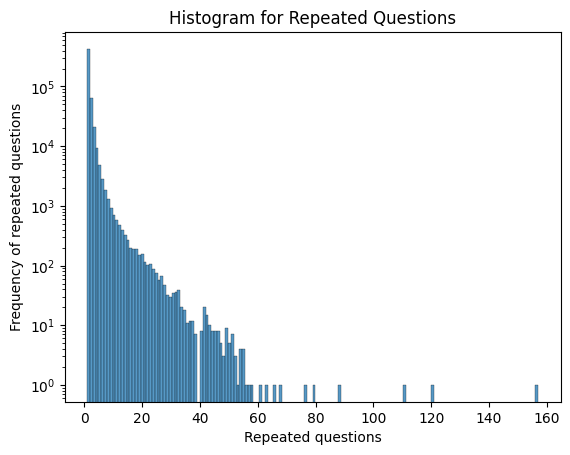

In [12]:
#Repeated Questions histogram
sns.histplot(qid.value_counts(), bins=160)
plt.yscale('log')
plt.xlabel("Repeated questions")
plt.ylabel("Frequency of repeated questions")
plt.title("Histogram for Repeated Questions")
plt.show()

# $$**----------**$$
## Without any Pre-processing
#### BoW and RFC

In [5]:
new_df = df.sample(30000, random_state=69)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
188277,188277,286753,286754,Why do we feel cold when we are ill?,Why do small illnesses like colds make you fee...,0
325462,325462,160263,451717,I booked some tickets on BookMyShow using net ...,If I have a debit card and I don't have a cred...,0
25041,25041,1775,46708,How on earth would I dress like a workout guy ...,How would I dress like a workout guy from the ...,1
53446,53446,94485,94486,What's the best POS system (iPad or not) for a...,What are the most useful gadgets for your iPho...,0
321887,321887,380388,447645,Why are clear face masks worn for basketball?,How can I make my face clean and soft?,0


In [6]:
new_df.fillna('', inplace=True)
new_df.dropna(subset=['question2'], inplace=True)

new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [7]:
new_df = new_df[['question1','question2','is_duplicate']]

new_df.head()

,question1,question2,is_duplicate
188277,Why do we feel cold when we are ill?,Why do small illnesses like colds make you fee...,0
325462,I booked some tickets on BookMyShow using net ...,If I have a debit card and I don't have a cred...,0
25041,How on earth would I dress like a workout guy ...,How would I dress like a workout guy from the ...,1
53446,What's the best POS system (iPad or not) for a...,What are the most useful gadgets for your iPho...,0
321887,Why are clear face masks worn for basketball?,How can I make my face clean and soft?,0


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
# Combine the 'question1' and 'question2' columns from the DataFrame 'new_df' into a single list 'ques'.
ques = list(new_df['question1']) + list(new_df['question2'])

len(ques)   # Calculate the total number of elements in the list 'ques'.

60000

In [10]:
# Initialize a CountVectorizer object 'cv' with a maximum of 4000 features.
cv = CountVectorizer(max_features=3000)

q1_arr, q2_arr = np.vsplit(cv.fit_transform(ques).toarray(), 2)

- Use the CountVectorizer to transform the list of questions 'ques' into a sparse matrix representation, then split the resulting matrix into two arrays 'q1_arr' and 'q2_arr' vertically along the middle.


In [11]:
# Converting above arrays into dataframes
temp_df1 = pd.DataFrame(q1_arr, index=new_df.index)
temp_df2 = pd.DataFrame(q2_arr, index=new_df.index)

temp_df = pd.concat([temp_df1,temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [12]:
temp_df['is_duplicate'] = new_df['is_duplicate']

temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
188277,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
325462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
53446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
321887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X = temp_df.iloc[:,:-1]
y = temp_df.iloc[:,-1]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=65)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [16]:
print("Accuracy Score without pre-processing: ", accuracy_score(y_pred,y_test)*100,"%")
print("\nClassification Report\n",classification_report(y_pred, y_test))

Accuracy Score without pre-processing:  73.29333333333334 %

Classification Report
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      5933
           1       0.42      0.73      0.53      1567

    accuracy                           0.73      7500
   macro avg       0.67      0.73      0.67      7500
weighted avg       0.81      0.73      0.75      7500



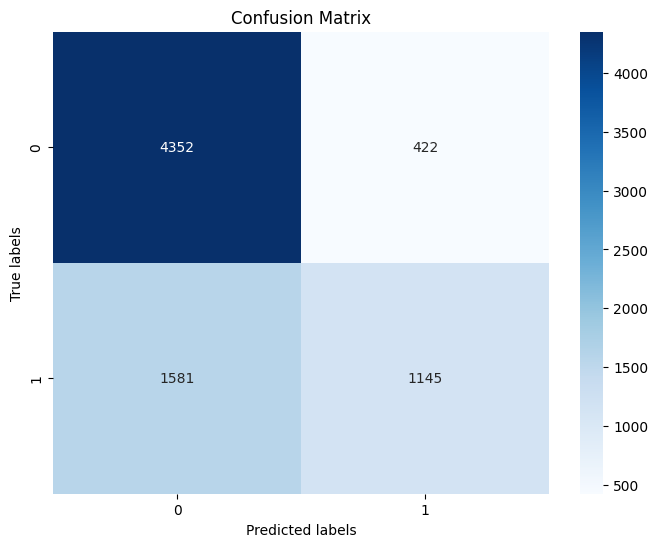

In [17]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#  $$**--- --------- ---**$$
# With Pre-Processing

### Feature Engineering
1. `q1 len`: Length of question 1 (q1) in terms of characters.
2. `q2 len`: Length of question 2 (q2) in terms of characters.
3. `q1 words`: Number of words in question 1 (q1).
4. `q2 words`: Number of words in question 2 (q2).
5. `words_common`: Number of words common to both question 1 (q1) and question 2 (q2).
6. `words_total`: Total number of unique words in both question 1 (q1) and question 2 (q2), considering each question separately.
7. `words_share`: Proportion of common words to total words in both question 1 (q1) and question 2 (q2). It is calculated as **words_common / words_total**.

## 1. Model Creation

In [5]:
df_new = df.sample(80000, random_state=69)
df_new.head()

,id,qid1,qid2,question1,question2,is_duplicate
188277,188277,286753,286754,Why do we feel cold when we are ill?,Why do small illnesses like colds make you fee...,0
325462,325462,160263,451717,I booked some tickets on BookMyShow using net ...,If I have a debit card and I don't have a cred...,0
25041,25041,1775,46708,How on earth would I dress like a workout guy ...,How would I dress like a workout guy from the ...,1
53446,53446,94485,94486,What's the best POS system (iPad or not) for a...,What are the most useful gadgets for your iPho...,0
321887,321887,380388,447645,Why are clear face masks worn for basketball?,How can I make my face clean and soft?,0


In [6]:
df_new.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
df_new.duplicated().sum()

0

is_duplicate
0    50414
1    29586
Name: count, dtype: int64


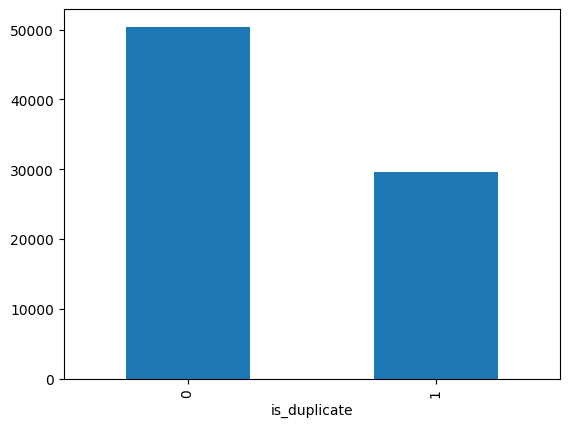

In [16]:
# Distribution of duplicate and non-duplicate questions
value_counts = df_new['is_duplicate'].value_counts()
print(value_counts)

value_counts.plot(kind='bar')
plt.show()

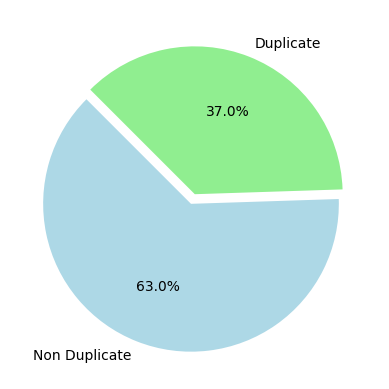

In [17]:
#Pie chart to show the distribution of dataset
explode = [0.07,0]
labels = ['Non Duplicate','Duplicate']
colors = ['lightblue','lightgreen']
autopct = "%1.1f%%"
plt.pie(value_counts, explode=explode, labels=labels, 
        colors=colors, autopct=autopct, startangle=135)
plt.show()

In [7]:
#Repeated Questions
qid = pd.concat([df_new['qid1'],df_new['qid2']])
print("Number of unique questions", np.unique(qid).shape[0])

x = qid.value_counts()>1
print("Number of repeated questions", x[x].shape[0])

Number of unique questions 135981
Number of repeated questions 14421


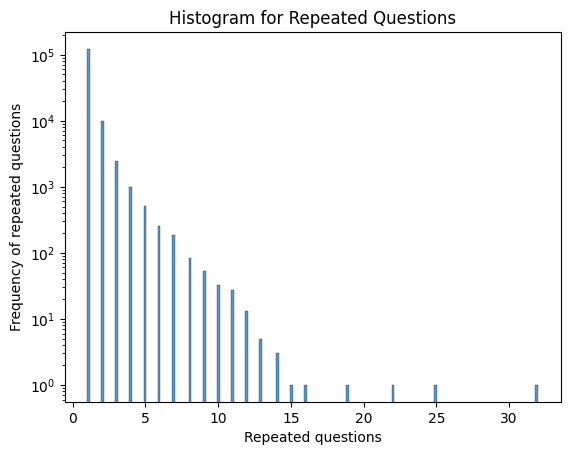

In [19]:
sns.histplot(qid.value_counts(), bins=160)
plt.yscale("log")
plt.xlabel("Repeated questions")
plt.ylabel("Frequency of repeated questions")
plt.title("Histogram for Repeated Questions")
plt.show()

## 2. Feature Engineering

In [8]:
# 1. Length of questions

df_new['q1_len']= df_new['question1'].str.len()
df_new['q2_len'] = df_new['question2'].str.len()

In [9]:
# 2. Words in questions
df_new['q1_num_words'] = df_new['question1'].apply(lambda row: len(str(row).split(" ")))
df_new['q2_num_words'] = df_new['question2'].apply(lambda row: len(str(row).split(" ")))

df_new.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
188277,188277,286753,286754,Why do we feel cold when we are ill?,Why do small illnesses like colds make you fee...,0,36,67,9,12
325462,325462,160263,451717,I booked some tickets on BookMyShow using net ...,If I have a debit card and I don't have a cred...,0,147,147,27,31
25041,25041,1775,46708,How on earth would I dress like a workout guy ...,How would I dress like a workout guy from the ...,1,79,56,17,12
53446,53446,94485,94486,What's the best POS system (iPad or not) for a...,What are the most useful gadgets for your iPho...,0,74,70,14,13
321887,321887,380388,447645,Why are clear face masks worn for basketball?,How can I make my face clean and soft?,0,45,38,8,9


In [10]:
# 3. Common words
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1&w2)

df_new['words_common'] = df_new.apply(common_words, axis=1)
df_new.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common
188277,188277,286753,286754,Why do we feel cold when we are ill?,Why do small illnesses like colds make you fee...,0,36,67,9,12,3
325462,325462,160263,451717,I booked some tickets on BookMyShow using net ...,If I have a debit card and I don't have a cred...,0,147,147,27,31,8
25041,25041,1775,46708,How on earth would I dress like a workout guy ...,How would I dress like a workout guy from the ...,1,79,56,17,12,11
53446,53446,94485,94486,What's the best POS system (iPad or not) for a...,What are the most useful gadgets for your iPho...,0,74,70,14,13,4
321887,321887,380388,447645,Why are clear face masks worn for basketball?,How can I make my face clean and soft?,0,45,38,8,9,1


In [11]:
# 4. Total words
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1)+len(w2))

df_new['words_total'] = df_new.apply(total_words, axis=1)
df_new.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common,words_total
188277,188277,286753,286754,Why do we feel cold when we are ill?,Why do small illnesses like colds make you fee...,0,36,67,9,12,3,20
325462,325462,160263,451717,I booked some tickets on BookMyShow using net ...,If I have a debit card and I don't have a cred...,0,147,147,27,31,8,45


In [12]:
# 5. Word share
df_new['words_share'] = round(df_new['words_common']/df_new['words_total'], 2)
df_new.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common,words_total,words_share
188277,188277,286753,286754,Why do we feel cold when we are ill?,Why do small illnesses like colds make you fee...,0,36,67,9,12,3,20,0.15
325462,325462,160263,451717,I booked some tickets on BookMyShow using net ...,If I have a debit card and I don't have a cred...,0,147,147,27,31,8,45,0.18


## 3. EDA (Exploratory Data Analysis)
### 3.1 Histogram for distribution of different parameters

Minimum characters for q1:  1
Maximum characters for q1:  413
Average characters for q1:  59


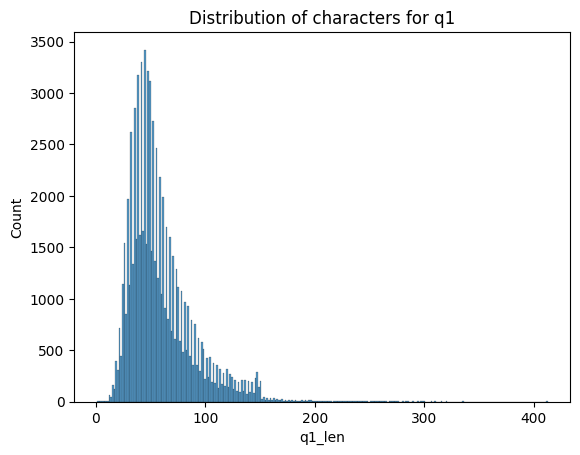

In [13]:
sns.histplot(df_new['q1_len'])
plt.title("Distribution of characters for q1")
print("Minimum characters for q1: ", df_new['q1_len'].min())
print("Maximum characters for q1: ", df_new['q1_len'].max())
print("Average characters for q1: ", int(df_new['q1_len'].mean()))

Minimum characters for q2:  4
Maximum characters for q2:  1151
Average characters for q2:  59


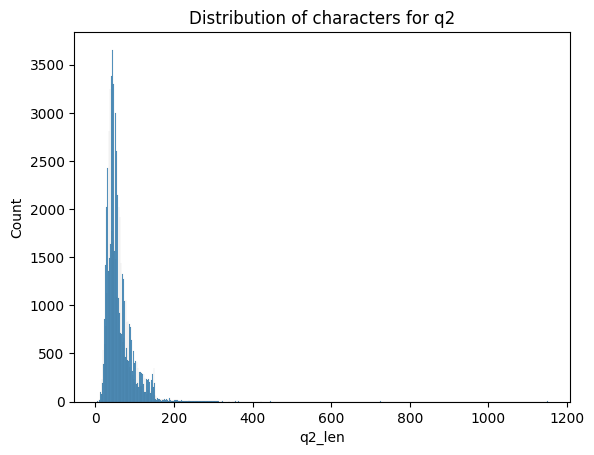

In [14]:
sns.histplot(df_new['q2_len'])
plt.title("Distribution of characters for q2")
print("Minimum characters for q2: ", df_new['q2_len'].min())
print("Maximum characters for q2: ", df_new['q2_len'].max())
print("Average characters for q2: ", int(df_new['q2_len'].mean()))

Minimum words for q1:  1
Maximum words for q1:  79
Average words for q1:  10


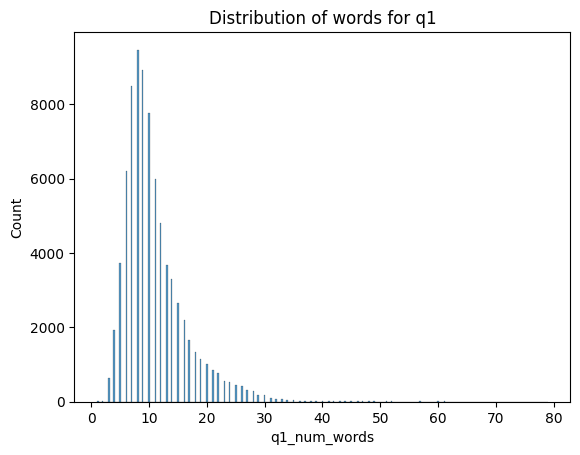

In [27]:
sns.histplot(df_new['q1_num_words'])
plt.title("Distribution of words for q1")
print("Minimum words for q1: ", df_new['q1_num_words'].min())
print("Maximum words for q1: ", df_new['q1_num_words'].max())
print("Average words for q1: ", int(df_new['q1_num_words'].mean()))

Minimum words for q2:  1
Maximum words for q2:  237
Average words for q2:  11


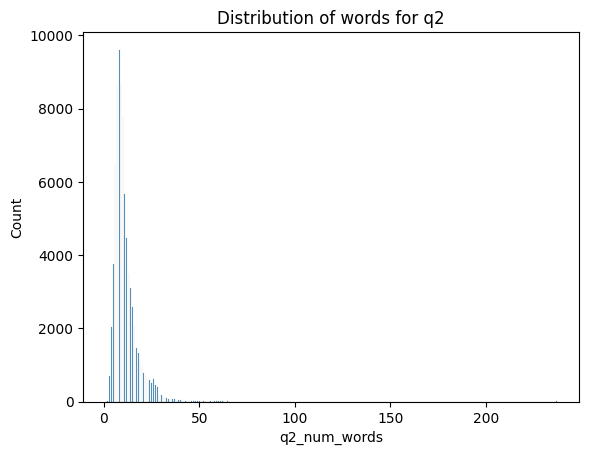

In [28]:
sns.histplot(df_new['q2_num_words'])
plt.title("Distribution of words for q2")
print("Minimum words for q2: ", df_new['q2_num_words'].min())
print("Maximum words for q2: ", df_new['q2_num_words'].max())
print("Average words for q2: ", int(df_new['q2_num_words'].mean()))

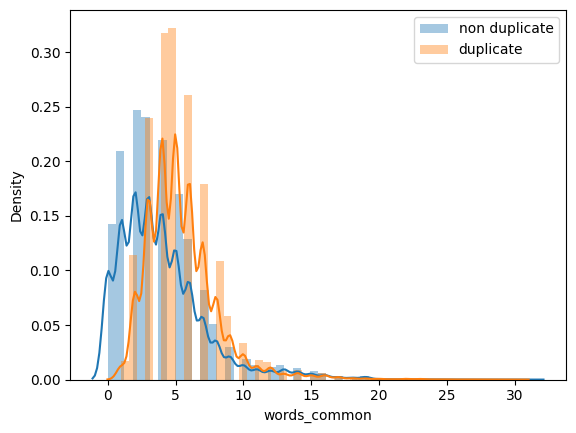

In [29]:
#COMMON WORDS
sns.distplot(df_new[df_new['is_duplicate']==0]['words_common'], label="non duplicate")
sns.distplot(df_new[df_new['is_duplicate']==1]['words_common'], label="duplicate")
plt.legend()
plt.show()

**Observation**
- When the common words are less than 3, it is less likely for the questions to be duplicates (non duplicate)
- Once the common words reach beyond 3, then there is more probability for the question pairs to be duplicated (duplicate)

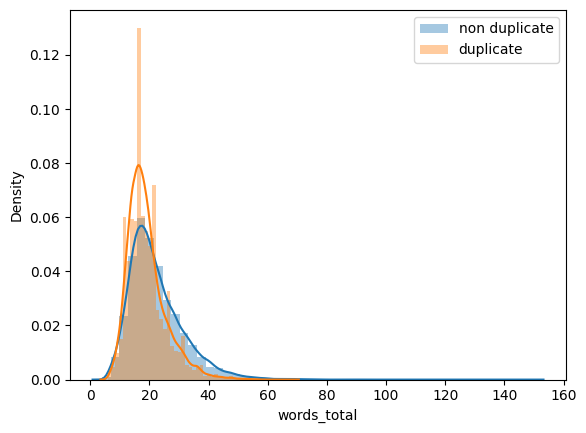

In [30]:
#TOTAL WORDS
sns.distplot(df_new[df_new['is_duplicate']==0]['words_total'], label="non duplicate")
sns.distplot(df_new[df_new['is_duplicate']==1]['words_total'], label="duplicate")
plt.legend()
plt.show()

**Observation**
- When the total words are less than 35, it is more likely for the questions to be duplicates of each other (duplicate)
- Once the total words reach beyond 35, then there is less probability for the question pairs to be duplicated (non duplicate)

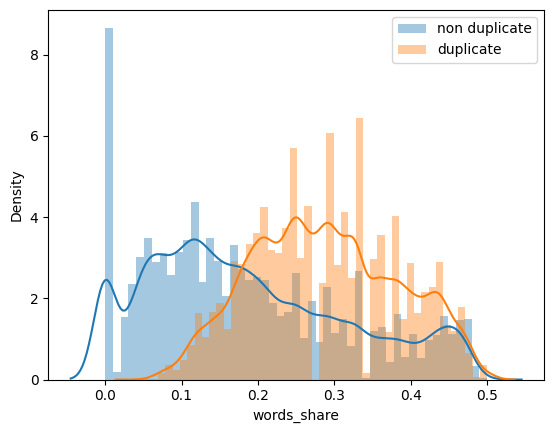

In [31]:
# WORD SHARE

sns.distplot(df_new[df_new['is_duplicate']==0]['words_share'], label="non duplicate")
sns.distplot(df_new[df_new['is_duplicate']==1]['words_share'], label="duplicate")
plt.legend()
plt.show()

**Observation**
- When the words share is less than 0.2, it is less likely for the questions to be duplicates of each other (non duplicate)
- Once the total words reach beyond 0.2, then there is more probability for the question pairs to be duplicated (duplicate)

### 3.2 Define new dataframes

In [15]:
ques_df = df_new[['question1','question2']]
ques_df.head(2)

,question1,question2
188277,Why do we feel cold when we are ill?,Why do small illnesses like colds make you fee...
325462,I booked some tickets on BookMyShow using net ...,If I have a debit card and I don't have a cred...


In [16]:
final_df = df_new.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)

(80000, 8)


In [17]:
final_df.head(2)

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common,words_total,words_share
188277,0,36,67,9,12,3,20,0.15
325462,0,147,147,27,31,8,45,0.18


### 3.3 Standardization using StandardScaler

In [18]:
from sklearn.preprocessing import StandardScaler

scaled_columns = ['q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'words_common', 'words_total', 'words_share']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
final_df[scaled_columns] = scaler.fit_transform(final_df[scaled_columns])

# Now, the specified columns have been scaled using StandardScaler


In [19]:
final_df.head(2)

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common,words_total,words_share
188277,0,-0.784935,0.213890,-0.357363,0.137710,-0.484463,-0.127152,-0.570496
325462,0,2.933600,2.603903,2.961388,3.183379,1.121753,2.805658,-0.337132


In [20]:
questions = list(ques_df['question1']) + list(ques_df['question2'])
len(questions)

160000

### 3.4 Text Preprocessing

In [21]:
import nltk
import re

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
# Initialize Porter Stemmer and stopwords
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Preprocess each question in the corpus
corpus = []
for question in questions:
    # Remove non-alphanumeric characters and convert to lowercase
    clean_question = re.sub(r'[^a-zA-Z0-9\s]', '', question.lower())
    # Tokenize the question
    tokens = clean_question.split()
    # Remove stopwords and apply stemming
    filtered_tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    # Join the tokens back into a string
    preprocessed_question = ' '.join(filtered_tokens)
    corpus.append(preprocessed_question)

In [23]:
len(corpus)

160000

## 4. MODEL BUILDING

#### 1. **Vectorizers**: 
* **CountVectorizer (Bag-of-Words Vectorizer)** - Converts text documents into a matrix of token counts
* **TfIdfVectorizer (TF-IDF Vectorizer)** - assigns weights to terms based on their frequency in a document relative to their frequency across all documents

#### 2. **Classifiers**
*  **Random Forest Classifier** - ensemble method that fits multiple decision tree classifiers on various sub-samples of the dataset and averages their predictions
* **Logistic Regression** - estimates the probability of a binary outcome based on one or more predictor variables.

### Count Vectorizer --- Classifiers --- Performance Metrics

### 4.1.1 CountVectorizer

In [41]:
# Initialize a CountVectorizer object 'cv' with a maximum of 3000 features.
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=3000)
X_cv = cv.fit_transform(corpus).toarray()
vocab = cv.get_feature_names_out()
print(vocab)

q1_arr, q2_arr = np.vsplit(cv.fit_transform(corpus).toarray(), 2)

temp_df1 = pd.DataFrame(q1_arr, index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index=ques_df.index)

temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

['10' '100' '1000' ... 'zealand' 'zero' 'zone']


(80000, 6000)

In [42]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)

(80000, 6008)


#### 4.1.1.1 Defining independent and dependent features

In [43]:
X = final_df.iloc[:,1:]
X.columns = X.columns.astype(str) # Converting each column into string datatype

#Target Labels
y = final_df.iloc[:,0]

#### 4.1.1.2 train-test split

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=67)

###  4.1.2 Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### 4.1.3 Performance Metrics

In [46]:
print("Accuracy Score using BoW and Random Forest: ", accuracy_score(y_pred,y_test)*100,"%")
print("\nClassification Report\n",classification_report(y_pred, y_test))

Accuracy Score using BoW and Random Forest:  78.7875 %

Classification Report
               precision    recall  f1-score   support

           0       0.87      0.81      0.84     10803
           1       0.65      0.74      0.69      5197

    accuracy                           0.79     16000
   macro avg       0.76      0.77      0.77     16000
weighted avg       0.80      0.79      0.79     16000



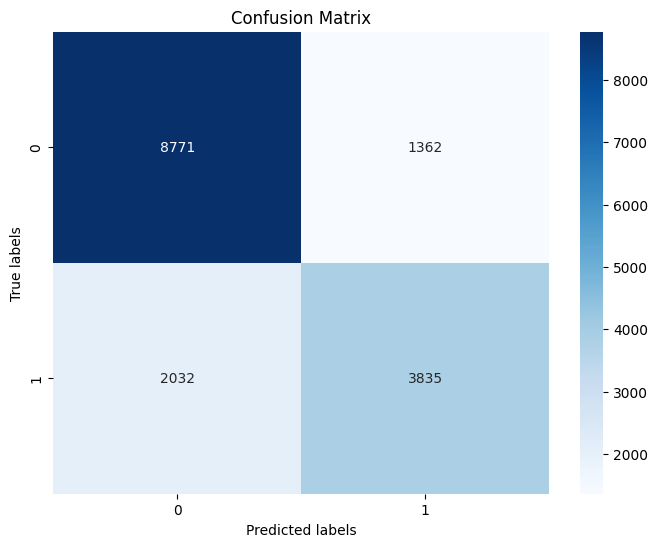

In [47]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 4.1.4 Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
y_pred_lgr_cv = lgr.predict(X_test)

### 4.1.5 Performance Metrics

In [52]:
print("Accuracy Score using BoW and Logistic Regression: ", accuracy_score(y_pred_lgr,y_test)*100,"%")
print("\nClassification Report\n",classification_report(y_pred_lgr, y_test))

Accuracy Score using BoW and Logistic Regression:  76.95 %

Classification Report
               precision    recall  f1-score   support

           0       0.84      0.80      0.82     10583
           1       0.65      0.70      0.67      5417

    accuracy                           0.77     16000
   macro avg       0.74      0.75      0.75     16000
weighted avg       0.77      0.77      0.77     16000



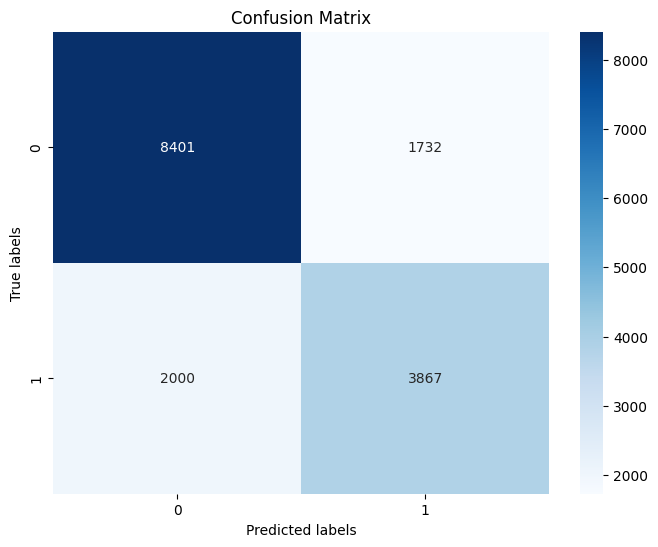

In [50]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_lgr_cv)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## TF-IDF Vectorizer  - Classifiers - Performance Metrics
### 4.2.1 TF-IDF Vectorizer

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(corpus).toarray()
vocab = tfidf.get_feature_names_out()

q1_arr, q2_arr = np.vsplit(tfidf.fit_transform(corpus).toarray(), 2)

temp_df1 = pd.DataFrame(q1_arr, index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index=ques_df.index)

temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(80000, 6000)

In [25]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)

(80000, 6008)


#### 4.2.1.1 Defining independent and dependent features

In [26]:
X = final_df.iloc[:,1:]
X.columns = X.columns.astype(str) # Converting each column into string datatype

#Target Labels
y = final_df.iloc[:,0]

#### 4.2.1.2 train-test split

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=67)

### 4.2.2 Random Forest Classifier 

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### 4.2.3 Performance Metrics

In [30]:
print("Accuracy Score using TF-IDF and Random Forest: ", accuracy_score(y_pred_rf,y_test)*100,"%")
print("\nClassification Report\n",classification_report(y_pred_rf, y_test))

Accuracy Score using TF-IDF and Random Forest:  78.49374999999999 %

Classification Report
               precision    recall  f1-score   support

           0       0.86      0.81      0.84     10790
           1       0.65      0.73      0.69      5210

    accuracy                           0.78     16000
   macro avg       0.76      0.77      0.76     16000
weighted avg       0.79      0.78      0.79     16000



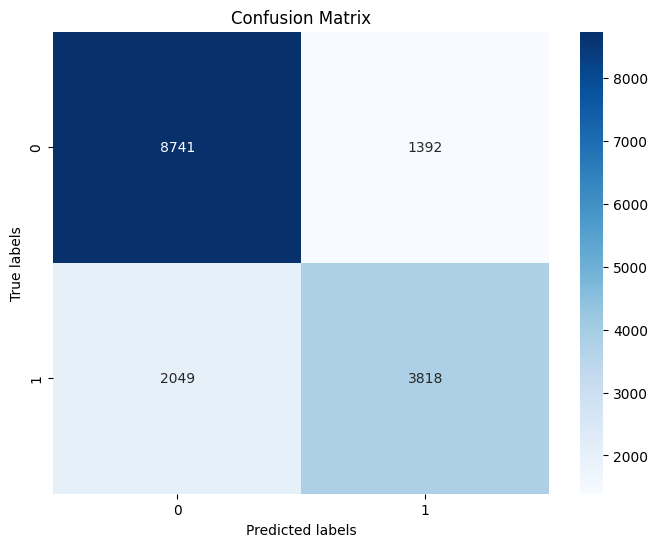

In [31]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 4.2.4 Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
y_pred_lgr = lgr.predict(X_test)

### 4.2.5 Performance Metrics

In [44]:
print("Accuracy Score using TF-IDF and Logistic Regression: ", accuracy_score(y_pred_lgr,y_test)*100,"%")
print("\nClassification Report\n",classification_report(y_pred_lgr, y_test))

Accuracy Score using TF-IDF and Logistic Regression:  76.95 %

Classification Report
               precision    recall  f1-score   support

           0       0.84      0.80      0.82     10583
           1       0.65      0.70      0.67      5417

    accuracy                           0.77     16000
   macro avg       0.74      0.75      0.75     16000
weighted avg       0.77      0.77      0.77     16000



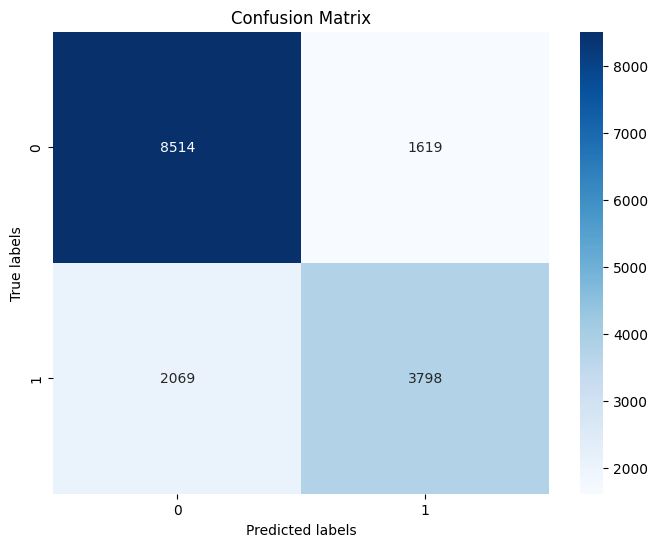

In [34]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_lgr)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Observations
- After initial model refinement efforts, including feature selection and creation of 7 new features, the model's performance improved by 3%.
- Further enhancements were made by implementing advanced text preprocessing techniques such as stemming and stopwords removal.
Standardization using StandardScaler() was employed to ensure consistent feature scaling across the dataset.
- The combined improvements aimed to refine the model's input data and enhance its predictive performance.

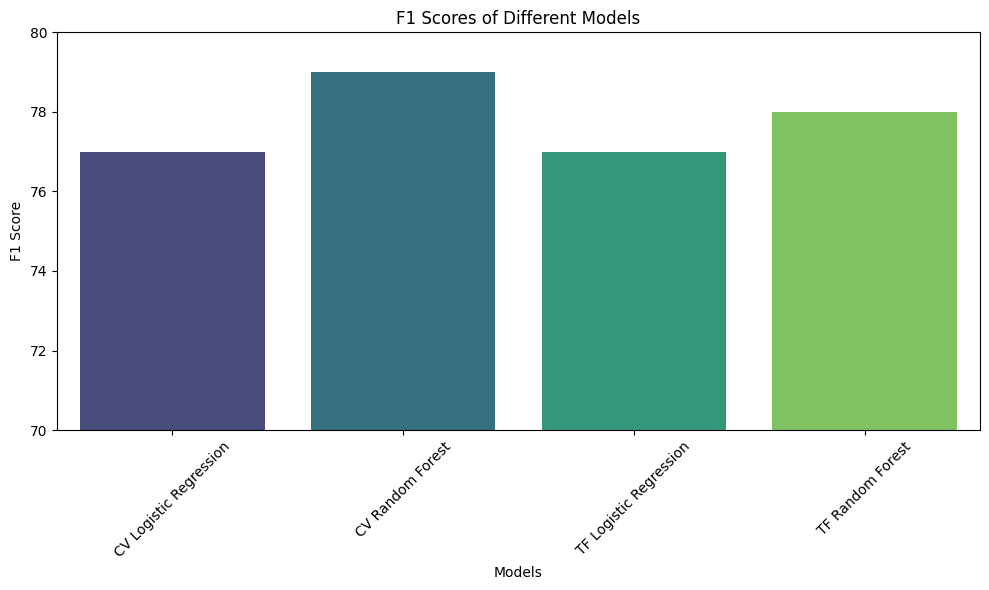

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define F1 scores and corresponding labels
f1_scores = [77, 79, 77, 78]
models = ['CV Logistic Regression', 'CV Random Forest', 'TF Logistic Regression', 'TF Random Forest']

# Create a barplot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=f1_scores, palette='viridis')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.ylim(70,80)
plt.title('F1 Scores of Different Models')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


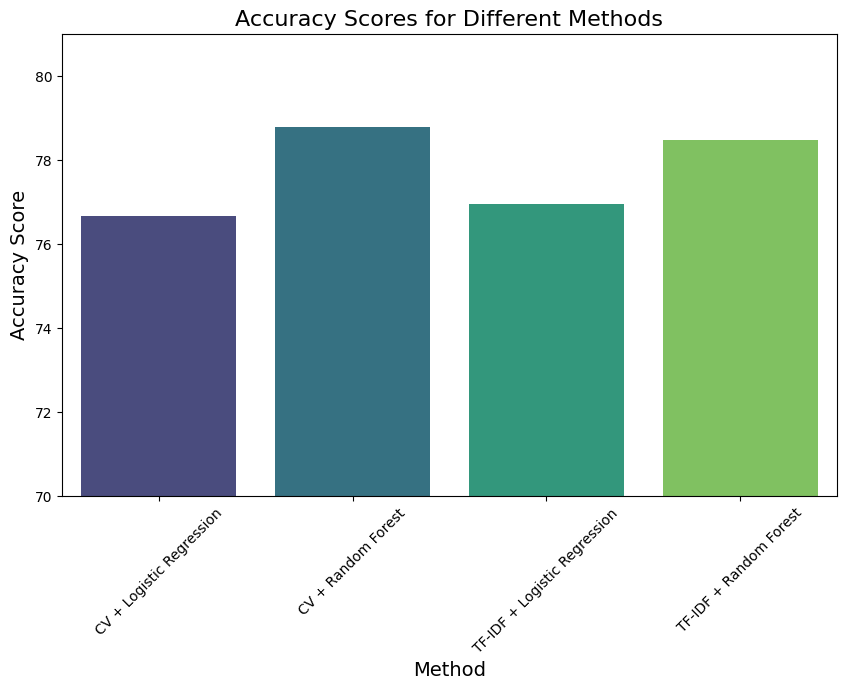

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
methods = ['CV + Logistic Regression', 'CV + Random Forest',
           'TF-IDF + Logistic Regression', 'TF-IDF + Random Forest']
accuracy_scores = [76.7, 78.78, 76.95, 78.49]

# Create a DataFrame from the data
data = {'Method': methods, 'Accuracy Score': accuracy_scores}
df = pd.DataFrame(data)

# Plot the bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y='Accuracy Score', x='Method', data=df, palette='viridis')
plt.title('Accuracy Scores for Different Methods', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=14)
plt.xlabel('Method', fontsize=14)
plt.ylim(70,81)
plt.xticks(rotation=45)  # Adjust the x-axis limits if needed
plt.show()
